{% include toc title = "In This Lesson" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this tutorial, you will be able to:

* Clean or "munge" social media data to prepare it for analysis.
* Explore and analyze word counts associated with tweets.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

You will need a computer with internet access to complete this lesson.

</div>

In this lesson, you will learn how to take a set of tweets and clean them, in order to analyze the frequency of words found in the tweets. You will learn how to do several things including:

1. Remove URLs from tweets.
2. Clean up tweet text, including differences in case (e.g. upper, lower) that will affect unique word counts and removing words that are not useful for the analysis. 
3. Summarize and count words found in tweets.


## Get Tweets Related to Climate

When you work with social media and other text data, the user community creates and curates the content. This means there are NO RULES! This also means that you may have to perform extra steps to clean the data to ensure you are analyzing the right thing.

Next, you will explore the text associated with a set of tweets that you access using `Tweepy` and the Twitter API. You will use some standard natural language processing (also known as text mining) approaches to do this.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

Remember to define your keys: 

```python 
consumer_key= 'yourkeyhere'
consumer_secret= 'yourkeyhere'
access_token= 'yourkeyhere'
access_token_secret= 'yourkeyhere'
```

In [2]:
consumer_key = os.environ['tw_consumer_key']
consumer_secret = os.environ['tw_consumer_secret']
access_token = os.environ['tw_access_token']
access_token_secret = os.environ['tw_access_secret']

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

Now that you've authenticated you're ready to search for tweets that contain `#climatechange`. Below you grab 1000 recent tweets and add them to a list. 

In [4]:
search_term = "#climate+change -filter:retweets"

tweets = tw.Cursor(api.search,
                   q=search_term,
                   lang="en",
                   since='2018-11-01').items(1000)

all_tweets = [tweet.text for tweet in tweets]

all_tweets[:5]

['How #Climate Change Scientists Are Learning To Get Their Message Across ... #Communications  #Science via @forbes https://t.co/NnsBYZRDNg',
 '@Obikonobe @LesIsMore1 @Bruce_Winter @JackieForrest @PTertzakian @RachelNotley Facts do not require your belief to… https://t.co/7L6o5DiVsA',
 "Here's How Much #Climate Change Could Cost the U.S. https://t.co/5KtsvZYCEY via @sciam",
 'The UN’s #CLIMATE Change Conference is Meeting…in Poland’s #COAL Country https://t.co/Y8Wt4CTSda #GPWX #GlobalWarming #climatechange',
 '"..and it highlights how the govt’s current abomination of a #climate change policy is not just hopelessly damaged… https://t.co/6h8kBcI5Tq']

## Remove URLs (links)

The tweets above have some elements that you do not want in your word counts. For instance, URLs will not be analyzed in this lesson. You can remove URLs (links) using regular expressions accessed from the `re` package. 

Re stands for `regular expressions`. Regular expressions are a special syntax that is used to identify patterns in a string. 

While this lesson will not cover regular expressions, it is helpful to understand that this syntax below:

`([^0-9A-Za-z \t])|(\w+:\/\/\S+)`

Tells the search to find all strings that look like a URL, and replace it with nothing -- `""`. It also removes other punctionation including hashtags - `#`.

`re.sub` allows you to substitute a selection of characters defined using a regular expression, with something else. 

In the function defined below, this line takes the text in each tweet and replaces the URL with `""` (nothing):
`re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet`

In [5]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

After defining the function, you can call it in a list comprehension to create a list of the clean tweets. 

In [6]:
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[:5]

['How Climate Change Scientists Are Learning To Get Their Message Across Communications Science via forbes',
 'Obikonobe LesIsMore1 BruceWinter JackieForrest PTertzakian RachelNotley Facts do not require your belief to',
 'Heres How Much Climate Change Could Cost the US via sciam',
 'The UNs CLIMATE Change Conference is Meetingin Polands COAL Country GPWX GlobalWarming climatechange',
 'and it highlights how the govts current abomination of a climate change policy is not just hopelessly damaged']

### Text Cleanup - Address Case Issues

Capitalization is also a challenge when analyzing text data. If you are trying to create a list of unique words in your tweets, words with capitalization will be different from words that are all lowercase.

In [7]:
# Note how capitalization impacts unique returned values
ex_list = ["Dog", "dog", "dog", "cat", "cat", ","]

# Get unique elements in the list
set(ex_list)

{',', 'Dog', 'cat', 'dog'}

To account for this, you can make each word lowercase using the string method `.lower()`. In the code below, this method is applied using a list comprehension.

In [8]:
# Note how capitalization impacts unique returned values
words_list = ["Dog", "dog", "dog", "cat", "cat", ","]

# Make all elements in the list lowercase
lower_case = [word.lower() for word in words_list]

# Get all elements in the list
lower_case

['dog', 'dog', 'dog', 'cat', 'cat', ',']

Now all of the words in your list are lowercase. You can again use `set()` function to return only unique words.

In [9]:
# Now you have only unique words
set(lower_case)

{',', 'cat', 'dog'}

## Create List of Lower Case Words from Tweets

Right now, you have a list of lists that contains each full tweet and you know how to lowercase the words.

However, to do a word frequency analysis, you need a list of all of the words associated with each tweet. You can use `.split()` to split out each word into a unique element in a list, as shown below.

In [10]:
# Split the words from one tweet into unique elements
all_tweets_no_urls[0].split()

['How',
 'Climate',
 'Change',
 'Scientists',
 'Are',
 'Learning',
 'To',
 'Get',
 'Their',
 'Message',
 'Across',
 'Communications',
 'Science',
 'via',
 'forbes']

Of course, you will notice above that you have a capital word in your list of words. 

You can combine `.lower()` with `.split()` to remove capital letters and split up the tweet in one step. Below is an example of applying these methods to the first tweet in the list. 

In [11]:
# Split the words from one tweet into unique elements
all_tweets_no_urls[0].lower().split()

['how',
 'climate',
 'change',
 'scientists',
 'are',
 'learning',
 'to',
 'get',
 'their',
 'message',
 'across',
 'communications',
 'science',
 'via',
 'forbes']

To split and lower case words in all of the tweets, you can string both methods `.lower()` and `.split()` together in a list comprehension.

In [12]:
# Create a list of lists containing lowercase words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
words_in_tweet[:2]

[['how',
  'climate',
  'change',
  'scientists',
  'are',
  'learning',
  'to',
  'get',
  'their',
  'message',
  'across',
  'communications',
  'science',
  'via',
  'forbes'],
 ['obikonobe',
  'lesismore1',
  'brucewinter',
  'jackieforrest',
  'ptertzakian',
  'rachelnotley',
  'facts',
  'do',
  'not',
  'require',
  'your',
  'belief',
  'to']]

### Calculate and Plot Word Frequency

To get the count of how many times each word appears in the sample, you can use the built-in `Python` library `collections`, which helps create a special type of a `Python dictonary.` The `collection.Counter` object has a useful built-in method `most_common` that will return the most commonly used words and the number of times that they are used. 

To begin, flatten your list, so that all words across the tweets are in one list. Note that you could flatten your list with another list comprehension like this:
`all_words = [item for sublist in tweets_nsw for item in sublist]`

However, it is actually faster to use `itertools` to flatten the list as follows.

In [13]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)

[('climate', 948),
 ('change', 655),
 ('the', 621),
 ('to', 404),
 ('of', 304),
 ('in', 243),
 ('and', 233),
 ('is', 220),
 ('on', 211),
 ('a', 201),
 ('we', 150),
 ('for', 145),
 ('are', 136),
 ('climatechange', 121),
 ('you', 82)]

Based on the counter, you can create a `Pandas Dataframe` for analysis and plotting that includes only the top 15 most common words. 

In [14]:
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,climate,948
1,change,655
2,the,621
3,to,404
4,of,304


Using this `Pandas Dataframe`, you can create a horizontal bar graph of the top 15 most common words in the tweets as shown below.  

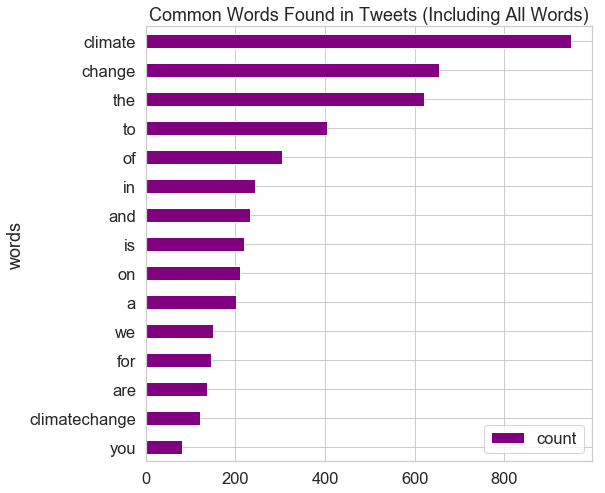

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

### Tweet Length Analysis

A tweet is limited to 280 characters. You can explore how many words (not including links) were used by people that recently tweeted about climate change. To do this, you will use the `len()` function to calculate the length of each list of words that are associated with each tweet.

In [ ]:
tweet_word_count = [len(word) for word in words_in_tweet]
tweet_word_count[:3]

You can use the list you created above to plot the distribution of tweet length.

In [ ]:
# Get the average word count
#average_word_count = np.mean(tweet_word_count)

# Print this value out in a text statement
#print('The average number of words in each tweet is %0.6f' % average_word_count)

#fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram
#ax.hist(tweet_word_count,
        #bins=50, color="purple")

# Add labels of specified sizes
#ax.set(xlabel="Word Count",
#       ylabel="Frequency",
#       title="Tweet Word Count Distribution")

# Plot a line for the average value
#ax.axvline(x=average_word_count,
#           lw=2,
#           color='red',
#           linestyle='--')
#plt.show()

## Remove Stopwords With `nltk`

In addition to lowercase words, you may also want to perform additional clean-up, such as removing words that do not add meaningful information to the text you are trying to analysis. These words referred to as "stop words" and include commonly appearing words such as who, what, you, etc.

The `Python` package `nltk`, commonly used for text analysis, provides a list of "stop words" that you can use to clean your Twitter data.

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jpalomino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop_words = set(stopwords.words('english'))

# View a few words from the set
list(stop_words)[0:10]

['wouldn',
 'our',
 'who',
 'under',
 're',
 'through',
 'down',
 'once',
 'between',
 'out']

Notice that the stop words provided by `nltk` are all lower-case. This works well given you already have converted all of your tweet words to lower case using the `Python` `string` method `.lower()`. 

Next, you will remove all stop words from each tweet. First, have a look at the words in the first tweet below.

In [23]:
words_in_tweet[0]

['how',
 'climate',
 'change',
 'scientists',
 'are',
 'learning',
 'to',
 'get',
 'their',
 'message',
 'across',
 'communications',
 'science',
 'via',
 'forbes']

Below, you remove all of the stop words in each tweet. The list comprehension below might look confusing as it is nested. The list comprehension below is the same as calling:

```python
for all_words in words_in_tweet:
    for a word in all_words:
        # remove stop words
```

Now, compare the words in the original tweet to the words in the tweet after the stop words are removed: 

In [24]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['climate',
 'change',
 'scientists',
 'learning',
 'get',
 'message',
 'across',
 'communications',
 'science',
 'via',
 'forbes']

Again, you can flatten your list and create a counter to return the most commonly used words and the number of times that they are used.  

In [25]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('climate', 948),
 ('change', 655),
 ('climatechange', 121),
 ('cop24', 68),
 ('via', 62),
 ('world', 61),
 ('us', 58),
 ('un', 52),
 ('amp', 47),
 ('globalwarming', 44),
 ('trump', 44),
 ('people', 41),
 ('action', 39),
 ('news', 39),
 ('gpwx', 36)]

Then, you can create the `Pandas Dataframe` and plot the word frequencies without the stop words. 

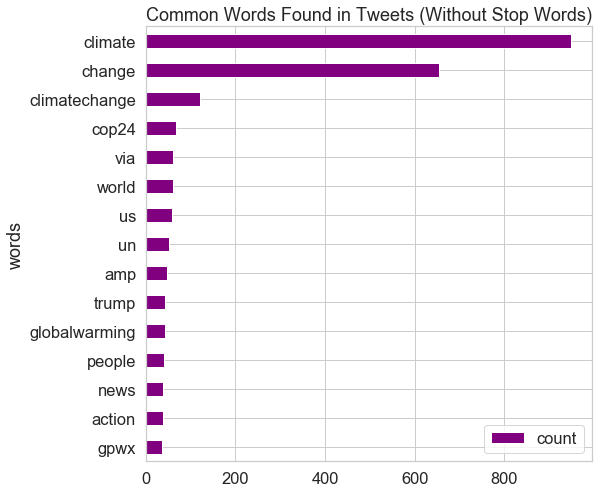

In [26]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

## Remove Collection Words

In additional to removing stopwords, it is common to also remove collection words. Collection words are the words that you used to query your data from Twitter. 

In this case, you used "climate change" as a collection term. Thus, you can expect that these terms will be found in each tweet. This could skew your word frequency analysis. 

Below you remove the collection words - climate, change, and climatechange - from the tweets through list comprehension.  

In [27]:
collection_words = ['climatechange', 'climate', 'change']

In [28]:
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

Compare the words in first tweet with and without the collection words.

In [29]:
tweets_nsw[0]

['climate',
 'change',
 'scientists',
 'learning',
 'get',
 'message',
 'across',
 'communications',
 'science',
 'via',
 'forbes']

In [30]:
tweets_nsw_nc[0]

['scientists',
 'learning',
 'get',
 'message',
 'across',
 'communications',
 'science',
 'via',
 'forbes']

## Calculate and Plot Word Frequency of Clean Tweets

Now that you have cleaned up your data, you are ready to calculate and plot the final word frequency results.

Using the skills you have learned, you can flatten the list and create the counter for the words in the tweets. 

In [31]:
# Flatten list of words in clean tweets
all_words_nsw_nc = list(itertools.chain(*tweets_nsw_nc))

# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(all_words_nsw_nc)

counts_nsw_nc.most_common(15)

[('cop24', 68),
 ('via', 62),
 ('world', 61),
 ('us', 58),
 ('un', 52),
 ('amp', 47),
 ('globalwarming', 44),
 ('trump', 44),
 ('people', 41),
 ('action', 39),
 ('news', 39),
 ('gpwx', 36),
 ('new', 36),
 ('climateaction', 34),
 ('threat', 33)]

To find out the number of unique words across all of the tweets, you can take the `len()` of the object counts that you just created. 

In [32]:
len(counts_nsw_nc)

3399

Last, you can create the `Pandas Dataframe` of the words and their counts and plot the top 15 most common words from the clean tweets (i.e. no URLs, stop words, or collection words). 

In [33]:
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(15),
                             columns=['words', 'count'])
clean_tweets_ncw.head()

,words,count
0,cop24,68
1,via,62
2,world,61
3,us,58
4,un,52


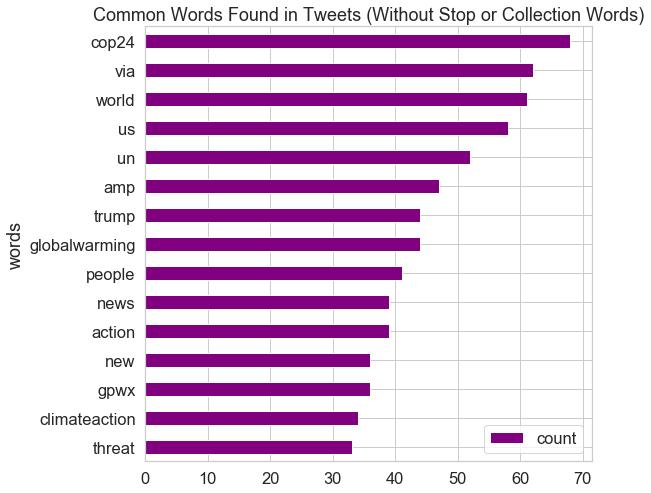

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")

plt.show()

You now know how to clean Twitter data, including how to remove URLs as well as stop and collection words. You also learned how to calculate and plot word frequencies. 

In the lessons that follow, you will analyze co-occurrence of words (i.e. bigrams) and attitudes (i.e. sentiments) in Tweets.